In [15]:
# 1. Load Latest Preprocessed Data 

# Find the most recent preprocessed data folder
preprocessed_dir = os.path.join('../..', 'data', 'preprocessed')
latest_folder = sorted([d for d in os.listdir(preprocessed_dir) if os.path.isdir(os.path.join(preprocessed_dir, d))])[-1]
latest_data_path = os.path.join(preprocessed_dir, latest_folder)
print(f"Loading data from the most recent folder: '{latest_data_path}'")

# Load the scaled data sets
X_train = pd.read_csv(os.path.join(latest_data_path, 'X_train_scaled.csv'))
y_train = pd.read_csv(os.path.join(latest_data_path, 'y_train_scaled.csv')).squeeze()
X_test = pd.read_csv(os.path.join(latest_data_path, 'X_test_scaled.csv'))
y_test = pd.read_csv(os.path.join(latest_data_path, 'y_test_scaled.csv')).squeeze()

print(f"\nData loaded successfully. Training with {len(X_train)} samples.")

Loading data from the most recent folder: '../../data/preprocessed/preprocessed_data_20250720_131842'

Data loaded successfully. Training with 1688 samples.


In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from optuna.integration import LightGBMPruningCallback

def objective(trial):
    """Optuna objective function for LightGBM with pruning enabled."""
    
    params = {
        'objective': 'multiclass', 'num_class': 7, 'metric': 'multi_logloss',
        'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50)
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        pruning_callback = LightGBMPruningCallback(trial, "multi_logloss")
        
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  eval_metric='multi_logloss',
                  callbacks=[pruning_callback, lgb.log_evaluation(period=0)])
        
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))

    # Return the error rate to be MINIMIZED 
    return 1.0 - np.mean(scores)

# Set the study direction to MINIMIZE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=1200) # Run 100 trials or for 20 minutes

# Final Results
print(f"\nNumber of finished trials: {len(study.trials)}")
# We convert the best value (error) back to accuracy for reporting
print(f"Best trial's accuracy: {1.0 - study.best_value:.4f}")
print("Best parameters found: ")
print(study.best_params)

Training the final model with the best pre-defined parameters...

--- Final Model Evaluation ---
Train Accuracy: 1.0000
Test Accuracy: 0.9740

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.89      0.97      0.93        58
           2       1.00      0.99      0.99        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.96      0.93      0.95        58
           6       1.00      1.00      1.00        58

    accuracy                           0.97       423
   macro avg       0.97      0.97      0.97       423
weighted avg       0.98      0.97      0.97       423


Generating Confusion Matrix...


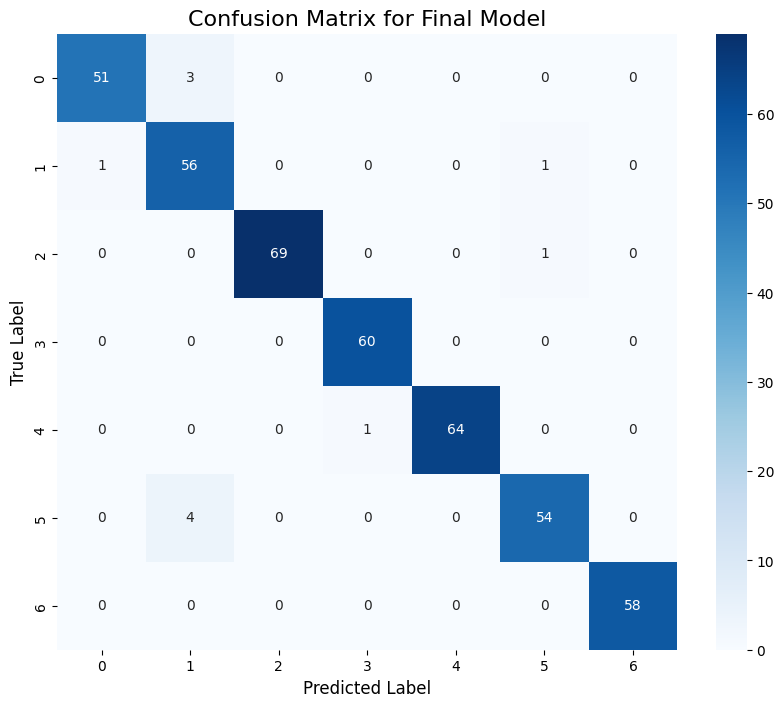


Generating Feature Importance Plot...


/var/folders/66/8_hjb53j5gn7z6wx8y9q2zl00000gn/T/ipykernel_10798/1518579766.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


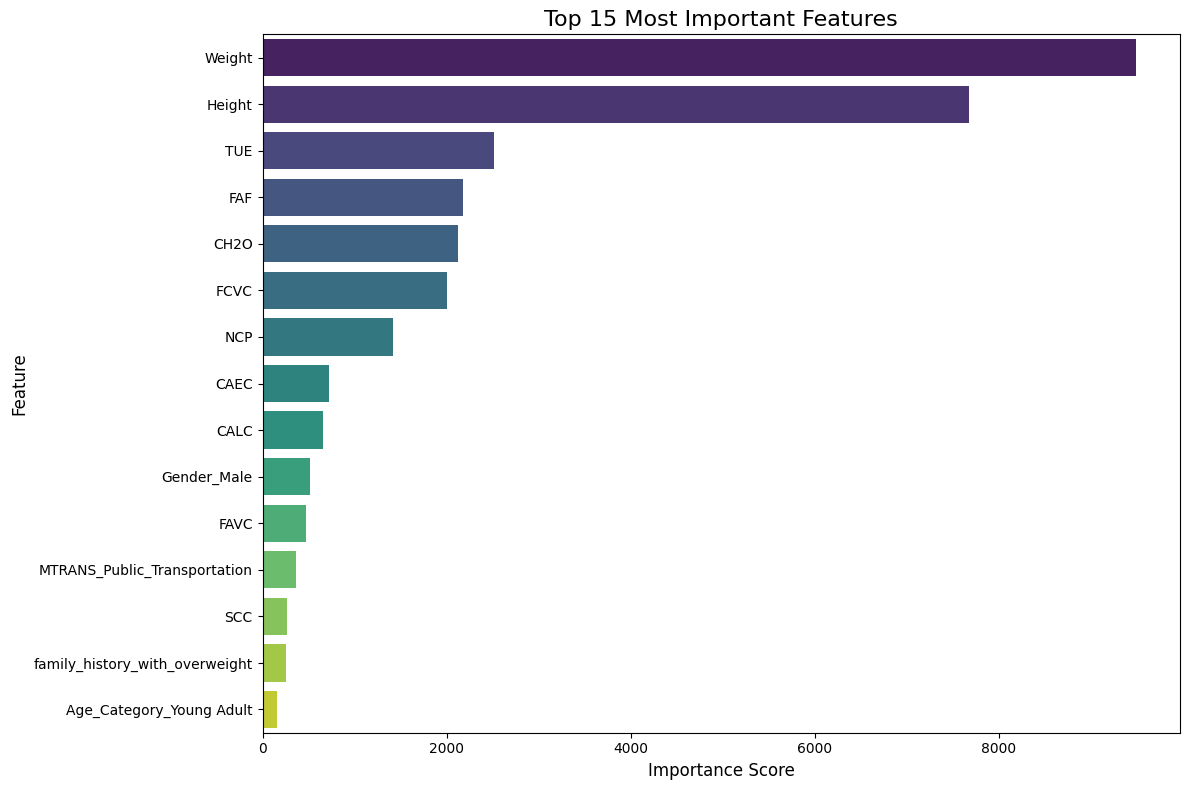

In [17]:
# Train and Evaluate the Final Model with Pre-defined Best Parameters 
import lightgbm as lgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Manually define the best parameters your friend found
best_params = {
    'n_estimators': 815,
    'learning_rate': 0.18502652149436183,
    'num_leaves': 70,
    'max_depth': 5,
    'min_child_samples': 45,
    'subsample': 0.6633868530528707,
    'colsample_bytree': 0.8785984716278369,
    'reg_alpha': 0.00011286229652520546,
    'reg_lambda': 0.01701653807848482,
    'objective': 'multiclass',
    'num_class': 7,
    'random_state': 42,
    'verbosity': -1
}

print("Training the final model with the best pre-defined parameters...")

# Initialize and train the final model
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Final Evaluation
print("\n--- Final Model Evaluation ---")

# Evaluate on the test set
y_pred_final = final_model.predict(X_test)
train_accuracy = accuracy_score(y_train, final_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred_final)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix Visualization
print("\nGenerating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_model.classes_,
            yticklabels=final_model.classes_)
plt.title('Confusion Matrix for Final Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# --- Feature Importance Visualization ---
print("\nGenerating Feature Importance Plot...")

feature_importance = final_model.feature_importances_
feature_names = X_train.columns.tolist()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Most Important Features', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


--- Generating SHAP values for model interpretation ---
Calculating SHAP values for 200 samples...

Generating SHAP summary plot...


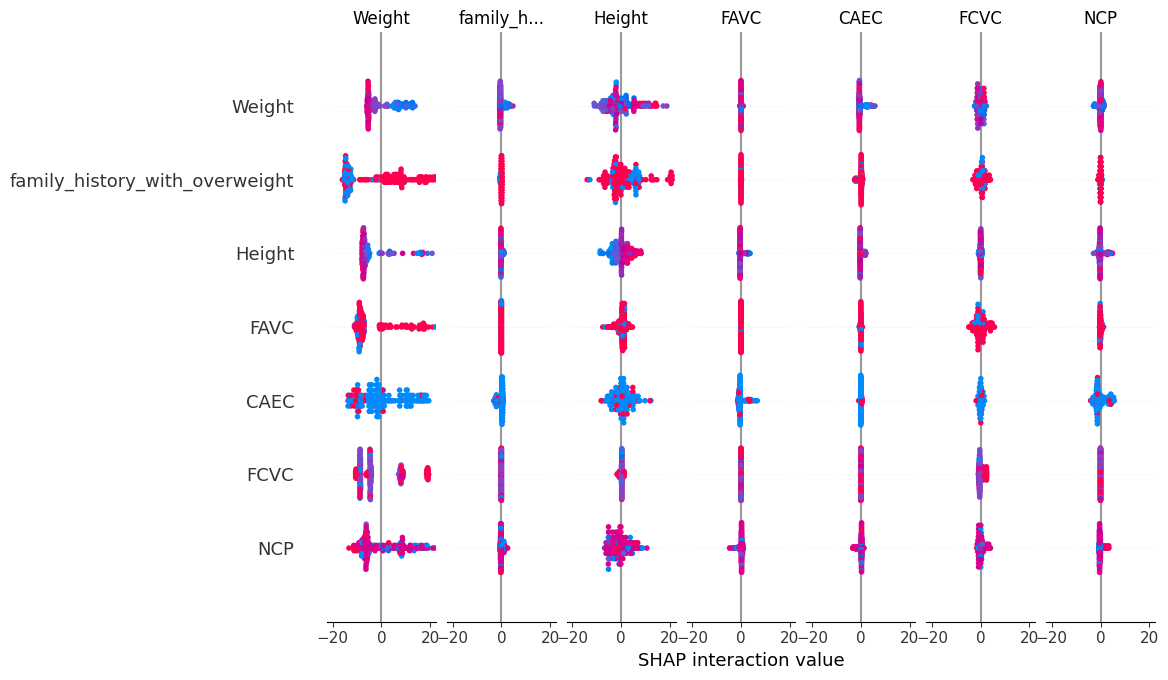

In [18]:
import shap

# --- SHAP Model Interpretation ---
print("\n--- Generating SHAP values for model interpretation ---")

# 1. Create the SHAP Explainer
# We use TreeExplainer because LightGBM is a tree-based model.
explainer = shap.TreeExplainer(final_model)

# 2. Calculate SHAP values
# It's computationally intensive, so we use a sample of the test data.
X_test_sample = X_test.sample(n=200, random_state=42)
print(f"Calculating SHAP values for {len(X_test_sample)} samples...")
shap_values = explainer.shap_values(X_test_sample)

# 3. Create the SHAP Summary Plot
# This is the most important visualization. It shows the impact of each feature
# across all the samples. Red dots are high feature values, blue are low.
print("\nGenerating SHAP summary plot...")
shap.summary_plot(shap_values, X_test_sample, class_names=final_model.classes_)


--- Generating SHAP Explanation for a Single Prediction ---
Calculating SHAP values for 200 samples...

Explaining prediction for sample #0, predicted as: '3'


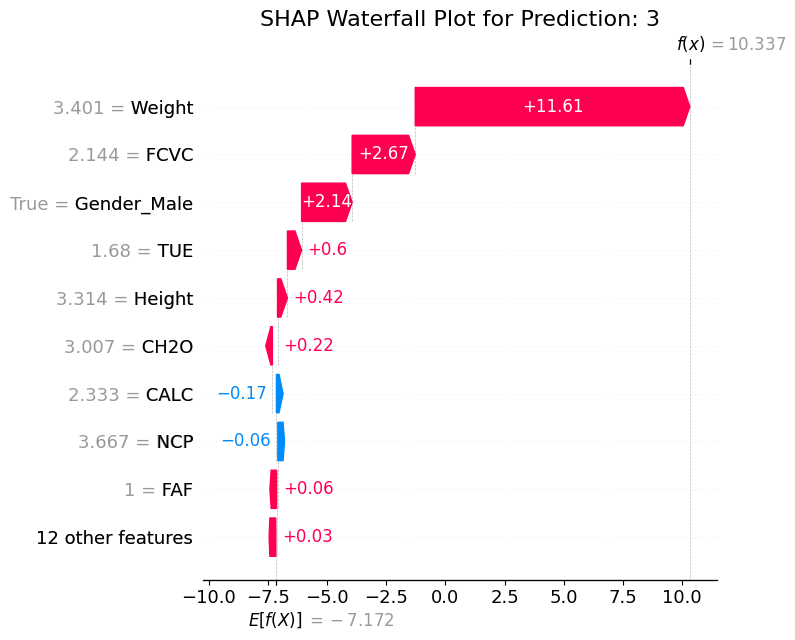

In [19]:
# --- SHAP Individual Prediction Explanation ---
print("\n--- Generating SHAP Explanation for a Single Prediction ---")

# 1. Initialize the SHAP Explainer with your final model
explainer = shap.Explainer(final_model)

# 2. Select a sample to explain (using the same sample from before)
# If X_test_sample doesn't exist, create it:
if 'X_test_sample' not in locals():
    X_test_sample = X_test.sample(n=200, random_state=42)

# 3. Calculate SHAP values for the sample
print(f"Calculating SHAP values for {len(X_test_sample)} samples...")
shap_values = explainer(X_test_sample)

# 4. Explain a single prediction (e.g., the first person in the sample)
sample_id = 0
predicted_class_index = final_model.predict(X_test_sample.iloc[[sample_id]])[0]
predicted_class_name = final_model.classes_[predicted_class_index]

print(f"\nExplaining prediction for sample #{sample_id}, predicted as: '{predicted_class_name}'")

# --- Generate the Waterfall Plot ---
# This plot shows how each feature contributes to the final prediction for one person
shap.plots.waterfall(shap_values[sample_id, :, predicted_class_index], show=False)
plt.title(f"SHAP Waterfall Plot for Prediction: {predicted_class_name}", fontsize=16)
plt.tight_layout()
plt.show()

In [20]:
import joblib
import json
from sklearn.preprocessing import StandardScaler

# This should be the variable holding your final, best-trained model
# In our last notebook, this was named 'final_model'
joblib.dump(final_model, 'lgbm_model.pkl')
print("Model saved as lgbm_model.pkl")

# Save the scaler that was fitted on your training data
final_scaler = StandardScaler().fit(X_train)
joblib.dump(final_scaler, 'scaler.pkl')
print("Scaler saved as scaler.pkl")

# Save the list of model columns to ensure consistency
model_columns = list(X_train.columns)
with open('model_columns.json', 'w') as f:
    json.dump(model_columns, f)
print("Model columns saved to model_columns.json")

Model saved as lgbm_model.pkl
Scaler saved as scaler.pkl
Model columns saved to model_columns.json
